In [53]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    accuracy_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import numpy as np

In [54]:
with open("/home/artemiy/rink_master/headers.html", "r", encoding="utf-8") as f:
    html_content = f.read()

soup = BeautifulSoup(html_content, "html.parser")

figcaptions = soup.find_all("figcaption")

for figcaption in figcaptions:
    figcaption_text = figcaption.text.strip()

    print(f"{figcaption_text}")

5-on-5 stats, General concepts
Assists, A
Assists (5-on-5), A (5-on-5)
Assists per 60 minutes (5-on-5), A/60 (5-on-5)
Assists per game played, A/GP
Attempts Blocked, A/B
Bench penalties, Bench
Birth country, Ctry
Blocked shots, BkS
Blocked shots per 60 minutes, BkS/60
Blocked shots per game played, BkS/GP
Career shootout game-deciding goals, Career GDG
Career shootout games played, Career SO GP
Career shootout goals, Career SO G
Career shootout shooting percentage, Career SO S%
Career shootout shot attempts, Career SO S
Close or close game, General concepts
Complete game percentage, CG%
Complete games, CG
Date of birth, DOB
Days between games, Days Btwn Games
Defensive zone face-off losses, DZ FOL
Defensive zone face-off win percentage, DZ FOW%
Defensive zone face-off wins, DZ FOW
Defensive zone face-offs, DZ FO
Draft round, Round
Draft year, Draft Yr
Empty net assists, ENA
Empty net goals, ENG
Empty net points, ENP
Enhanced statistics, General concepts
Even-strength face-off losses, E

In [55]:
pd.set_option("display.max_columns", None)

In [56]:
df = pd.read_csv(
    "/home/artemiy/rink_master/rink_master_data/rink_master_47816_wteams.csv"
)
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,Tie,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct
0,2003020001,2003-10-08,New Jersey Devils,Boston Bruins,1,1,0,0,1,0,1,0.5,0,0,0,3,3,3.0,3.0,0.75,0.75,0.75,0.75,35.0,31.0,0.43
1,2003020003,2003-10-08,Minnesota Wild,Chicago Blackhawks,1,1,0,1,0,0,0,0.0,0,0,0,0,1,0.0,1.0,0.00,1.00,0.00,1.00,33.0,22.0,0.57
2,2003020002,2003-10-08,Dallas Stars,Anaheim Ducks,0,1,1,0,0,0,2,1.0,1,1,0,4,1,4.0,1.0,0.33,0.75,0.33,0.75,22.0,21.0,0.53
3,2003020001,2003-10-08,Boston Bruins,New Jersey Devils,0,1,0,0,1,0,1,0.5,0,0,0,3,3,3.0,3.0,0.25,0.25,0.25,0.25,31.0,35.0,0.57
4,2003020003,2003-10-08,Chicago Blackhawks,Minnesota Wild,0,1,1,0,0,0,2,1.0,1,1,0,1,0,1.0,0.0,0.00,1.00,0.00,1.00,22.0,33.0,0.43


In [57]:
df["gameDate"] = pd.to_datetime(df["gameDate"])

# Берем последние 5 сезонов

In [58]:
df["Year"] = df["gameDate"].dt.year
df["Month"] = df["gameDate"].dt.month
df["Season"] = df.apply(
    lambda row: (
        f"{row['Year']}-{row['Year']+1}"
        if row["Month"] >= 10
        else f"{row['Year']-1}-{row['Year']}"
    ),
    axis=1,
)

In [59]:
last_seasons = df["Season"].unique()[-5:]
df = df[df["Season"].isin(last_seasons)].reset_index(drop=True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11772 entries, 0 to 11771
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   gameID               11772 non-null  int64         
 1   gameDate             11772 non-null  datetime64[ns]
 2   Team                 11772 non-null  object        
 3   Opponent             11772 non-null  object        
 4   homeRoad             11772 non-null  int64         
 5   gamesPlayed          11772 non-null  int64         
 6   Win                  11772 non-null  int64         
 7   Loss                 11772 non-null  int64         
 8   Tie                  11772 non-null  int64         
 9   OTLoss               11772 non-null  int64         
 10  points               11772 non-null  int64         
 11  pointPct             11772 non-null  float64       
 12  regulationWins       11772 non-null  int64         
 13  regulationAndOtWins  11772 non-

In [61]:
df.groupby('Season').size()

Season
2019-2020    2164
2020-2021    1736
2021-2022    2624
2022-2023    2624
2023-2024    2624
dtype: int64

In [62]:
# Исключение первых 10 игр каждой команды в каждом сезоне
df["gameNumber"] = df.groupby(["Team", "Season"]).cumcount() + 1
df = df[df["gameNumber"] > 10]

In [63]:
non_zero_counts = {
    "Tie": df["Tie"].astype(bool).sum(),
    "OTLoss": df["OTLoss"].astype(bool).sum(),
    "regulationWins": df["regulationWins"].astype(bool).sum(),
    "regulationAndOtWins": df["regulationAndOtWins"].astype(bool).sum(),
    "shootoutWins": df["shootoutWins"].astype(bool).sum(),
}

In [64]:
for column, count in non_zero_counts.items():
    print(f"{column}: {count} ненулевых значений")

Tie: 0 ненулевых значений
OTLoss: 1123 ненулевых значений
regulationWins: 3964 ненулевых значений
regulationAndOtWins: 4729 ненулевых значений
shootoutWins: 366 ненулевых значений


In [65]:
df = df.drop(columns=['Tie'])

In [66]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber
257,2019020132,2019-10-21,Dallas Stars,Ottawa Senators,0,1,1,0,0,2,1.0,1,1,0,2,1,2.0,1.0,0.20,1.00,0.20,1.00,43.0,20.0,0.50,2019,10,2019-2020,11
265,2019020141,2019-10-22,Vegas Golden Knights,Chicago Blackhawks,1,1,1,0,0,2,1.0,0,0,1,1,1,1.0,1.0,0.00,1.00,0.00,1.00,34.0,32.0,0.46,2019,10,2019-2020,11
267,2019020140,2019-10-22,Winnipeg Jets,Los Angeles Kings,0,1,0,1,0,0,0.0,0,0,0,2,3,2.0,3.0,0.00,0.75,0.00,0.75,28.0,41.0,0.43,2019,10,2019-2020,11
277,2019020142,2019-10-22,Washington Capitals,Calgary Flames,1,1,1,0,0,2,1.0,1,1,0,5,3,5.0,3.0,0.00,0.75,0.00,0.75,30.0,35.0,0.49,2019,10,2019-2020,11
279,2019020133,2019-10-22,Toronto Maple Leafs,Boston Bruins,1,1,0,1,0,0,0.0,0,0,0,2,4,2.0,4.0,0.25,0.75,0.25,0.75,30.0,39.0,0.40,2019,10,2019-2020,11


# Анализ игр, завершившихся не в основное время 

In [67]:
count_special_cases = df[
    (df["Win"] == 0)
    & (df["Loss"] == 0)
    & (
        (df["OTLoss"] != 0)
        | (df["regulationWins"] != 0)
        | (df["regulationAndOtWins"] != 0)
        | (df["shootoutWins"] != 0)
    )
].shape[0]

print(
    f"Строки, где Win и Loss равны 0, но OTLoss, regulationWins или regulationAndOtWins не равны 0: {count_special_cases}"
)

Строки, где Win и Loss равны 0, но OTLoss, regulationWins или regulationAndOtWins не равны 0: 1123


In [68]:
df["NonRegulationTime"] = df.apply(
    lambda row: row["OTLoss"] != 0 or row["shootoutWins"] != 0, axis=1
)

In [69]:
games_by_season = (
    df.groupby(["Season", "NonRegulationTime"]).size().unstack(fill_value=0)
)

In [70]:
games_by_season.columns = ["RegulationTime", "NonRegulationTime"]

In [71]:
games_by_season["TotalGames"] = (
    games_by_season["RegulationTime"] + games_by_season["NonRegulationTime"]
)

In [72]:
games_by_season["PercentNonRegulation"] = (
    games_by_season["NonRegulationTime"] / games_by_season["TotalGames"]
) * 100

In [73]:
mean_nonregulation = games_by_season["PercentNonRegulation"].mean().round(2)
print(
    f"Срений процент встреч, завершившихся не в основное время с 2019-20 по 2023-24 - {mean_nonregulation}%"
)

Срений процент встреч, завершившихся не в основное время с 2019-20 по 2023-24 - 14.59%


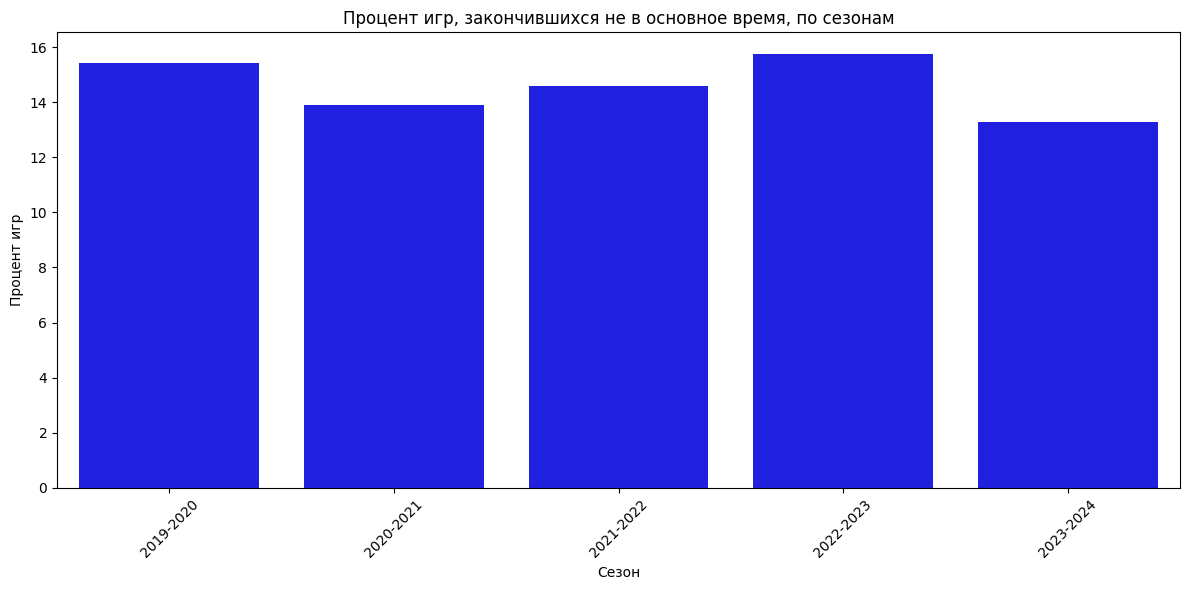

In [74]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=games_by_season.reset_index(),
    x="Season",
    y="PercentNonRegulation",
    color="blue",
)

plt.title("Процент игр, закончившихся не в основное время, по сезонам")
plt.xlabel("Сезон")
plt.ylabel("Процент игр")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Скользящие средние

In [75]:
def determine_result(row):
    if (
        row["Win"] != 0
        or row["regulationWins"] != 0
        or row["regulationAndOtWins"] != 0
        or row["shootoutWins"] != 0
    ):
        return 1  # Победа
    elif row["Loss"] != 0 or row["OTLoss"] != 0:
        return 0  # Поражение
    else:
        return -1  # Неопределено

In [76]:
df["Result"] = df.apply(determine_result, axis=1)

In [77]:
df = df.sort_values(by="gameDate")

### Добавление серий побед и поражений

In [78]:
def calculate_streaks(group):
    group = group.sort_values(by="gameDate")

    group["streak_Win"] = 0
    group["streak_Loss"] = 0

    current_streak_Win = 0
    current_streak_Loss = 0

    for i in range(len(group)):
        result = group.iloc[i]["Result"]
        if result == 1:  # Победа
            current_streak_Win += 1
            current_streak_Loss = 0
        elif result == 0:  # Поражение
            current_streak_Loss += 1
            current_streak_Win = 0
        else:
            current_streak_Win = 0
            current_streak_Loss = 0

        group.at[group.index[i], "streak_Win"] = current_streak_Win
        group.at[group.index[i], "streak_Loss"] = current_streak_Loss

    return group

In [79]:
# df = df.reset_index()

In [80]:
df = df.groupby("Team", group_keys=False).apply(calculate_streaks)

/tmp/ipykernel_281644/1167559267.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Team", group_keys=False).apply(calculate_streaks)


In [81]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber,NonRegulationTime,Result,streak_Win,streak_Loss
257,2019020132,2019-10-21,Dallas Stars,Ottawa Senators,0,1,1,0,0,2,1.0,1,1,0,2,1,2.0,1.0,0.20,1.00,0.20,1.00,43.0,20.0,0.50,2019,10,2019-2020,11,False,1,1,0
265,2019020141,2019-10-22,Vegas Golden Knights,Chicago Blackhawks,1,1,1,0,0,2,1.0,0,0,1,1,1,1.0,1.0,0.00,1.00,0.00,1.00,34.0,32.0,0.46,2019,10,2019-2020,11,True,1,1,0
267,2019020140,2019-10-22,Winnipeg Jets,Los Angeles Kings,0,1,0,1,0,0,0.0,0,0,0,2,3,2.0,3.0,0.00,0.75,0.00,0.75,28.0,41.0,0.43,2019,10,2019-2020,11,False,0,0,1
277,2019020142,2019-10-22,Washington Capitals,Calgary Flames,1,1,1,0,0,2,1.0,1,1,0,5,3,5.0,3.0,0.00,0.75,0.00,0.75,30.0,35.0,0.49,2019,10,2019-2020,11,False,1,1,0
279,2019020133,2019-10-22,Toronto Maple Leafs,Boston Bruins,1,1,0,1,0,0,0.0,0,0,0,2,4,2.0,4.0,0.25,0.75,0.25,0.75,30.0,39.0,0.40,2019,10,2019-2020,11,False,0,0,1


In [82]:
def rolling_features(group):
    group = group.sort_values(by="gameDate")

    # Скользящее среднее по количеству заброшенных и пропущенных голов
    group["rolling_goalsFor"] = (
        group["goalsFor"].rolling(window=5, min_periods=1).mean()
    )
    group["rolling_goalsAgainst"] = (
        group["goalsAgainst"].rolling(window=5, min_periods=1).mean()
    )

    # Скользящее по % реализации бросков
    group["rolling_shotGoalsPct"] = (
        (group["goalsFor"] / group["shotsForPerGame"])
        .rolling(window=5, min_periods=1)
        .mean()
    )

    # Скользящее по % сейвов
    group["rolling_savePct"] = (
        (
            (group["shotsAgainstPerGame"] - group["goalsAgainst"])
            / group["shotsAgainstPerGame"].replace(
                0, np.nan  # Избегайте деления на ноль
            )
        )
        .rolling(window=5, min_periods=1)
        .mean()
    )

    # Скользящее среднее по победам и поражениям
    group["rolling_Win"] = group["Win"].rolling(window=5, min_periods=1).mean()
    group["rolling_Loss"] = group["Loss"].rolling(window=5, min_periods=1).mean()

    # Скользящее среднее по проценту реализации большинства и меньшинства
    group["rolling_powerPlayPct"] = (
        group["powerPlayPct"].rolling(window=5, min_periods=1).mean()
    )
    group["rolling_penaltyKillPct"] = (
        group["penaltyKillPct"].rolling(window=5, min_periods=1).mean()
    )

    # Скользящее среднее по результату матча
    group["Result"] = group.apply(determine_result, axis=1)
    group["rolling_Result"] = group["Result"].rolling(window=5, min_periods=1).mean()

    # Скользящее по нанесенным броскам и полученным броскам
    group["rolling_shotsFor"] = (
        group["shotsForPerGame"].rolling(window=5, min_periods=1).mean()
    )
    group["rolling_shotsAgainst"] = (
        group["shotsAgainstPerGame"].rolling(window=5, min_periods=1).mean()
    )

    # Эффективность большинства и меньшинства
    group["rolling_powerPlayNetPct"] = (
        group["powerPlayNetPct"].rolling(window=5, min_periods=1).mean()
    )
    group["rolling_penaltyKillNetPct"] = (
        group["penaltyKillNetPct"].rolling(window=5, min_periods=1).mean()
    )

    # Скользящее по оличеству побед в домашних и гостевых матчах
    group["rolling_homeWin"] = (
        group[group["homeRoad"] == 1]["Win"].rolling(window=5, min_periods=1).mean()
    )
    group["rolling_roadWin"] = (
        group[group["homeRoad"] == 0]["Win"].rolling(window=5, min_periods=1).mean()
    )

    # Округление выбранных столбцов до 2 знаков после запятой
    columns_to_round = [
        "powerPlayPct",
        "powerPlayNetPct",
        "penaltyKillPct",
        "penaltyKillNetPct",
        "rolling_goalsFor",
        "rolling_goalsAgainst",
        "rolling_shotGoalsPct",
        "rolling_savePct",
        "rolling_Win",
        "rolling_Loss",
        "rolling_powerPlayPct",
        "rolling_penaltyKillPct",
        "rolling_Result",
        "rolling_shotsFor",
        "rolling_shotsAgainst",
        "rolling_powerPlayNetPct",
        "rolling_penaltyKillNetPct",
        "rolling_homeWin",
        "rolling_roadWin",
    ]
    group[columns_to_round] = group[columns_to_round].round(2)

    return group

In [83]:
# проверка на дубли
def find_duplicate_columns(df):
    duplicate_columns = []
    columns = df.columns

    for i, col1 in enumerate(columns):
        for col2 in columns[i + 1 :]:
            if df[col1].equals(df[col2]):
                duplicate_columns.append((col1, col2))

    return duplicate_columns


duplicates = find_duplicate_columns(df)
print(f"Duplicate columns: {duplicates}")

Duplicate columns: [('Win', 'Result')]


In [84]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber,NonRegulationTime,Result,streak_Win,streak_Loss
257,2019020132,2019-10-21,Dallas Stars,Ottawa Senators,0,1,1,0,0,2,1.0,1,1,0,2,1,2.0,1.0,0.20,1.00,0.20,1.00,43.0,20.0,0.50,2019,10,2019-2020,11,False,1,1,0
265,2019020141,2019-10-22,Vegas Golden Knights,Chicago Blackhawks,1,1,1,0,0,2,1.0,0,0,1,1,1,1.0,1.0,0.00,1.00,0.00,1.00,34.0,32.0,0.46,2019,10,2019-2020,11,True,1,1,0
267,2019020140,2019-10-22,Winnipeg Jets,Los Angeles Kings,0,1,0,1,0,0,0.0,0,0,0,2,3,2.0,3.0,0.00,0.75,0.00,0.75,28.0,41.0,0.43,2019,10,2019-2020,11,False,0,0,1
277,2019020142,2019-10-22,Washington Capitals,Calgary Flames,1,1,1,0,0,2,1.0,1,1,0,5,3,5.0,3.0,0.00,0.75,0.00,0.75,30.0,35.0,0.49,2019,10,2019-2020,11,False,1,1,0
279,2019020133,2019-10-22,Toronto Maple Leafs,Boston Bruins,1,1,0,1,0,0,0.0,0,0,0,2,4,2.0,4.0,0.25,0.75,0.25,0.75,30.0,39.0,0.40,2019,10,2019-2020,11,False,0,0,1


In [85]:
# df = df.sort_values(by="gameDate")

In [86]:
df.tail()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber,NonRegulationTime,Result,streak_Win,streak_Loss
11766,2023021312,2024-04-18,Los Angeles Kings,Chicago Blackhawks,0,1,1,0,0,2,1.0,0,1,0,5,4,5.0,4.0,0.50,0.00,0.50,0.000000,35.0,13.0,0.64,2024,4,2023-2024,82,False,1,1,0
11767,2023021309,2024-04-18,San Jose Sharks,Calgary Flames,1,1,0,1,0,0,0.0,0,0,0,1,5,1.0,5.0,0.50,1.00,0.50,1.000000,17.0,37.0,0.58,2024,4,2023-2024,82,False,0,0,3
11768,2023021307,2024-04-18,Minnesota Wild,Seattle Kraken,0,1,0,1,0,0,0.0,0,0,0,3,4,3.0,4.0,0.50,0.67,0.00,0.666666,24.0,27.0,0.41,2024,4,2023-2024,82,False,0,0,1
11769,2023021308,2024-04-18,Winnipeg Jets,Vancouver Canucks,0,1,1,0,0,2,1.0,1,1,0,4,2,4.0,2.0,0.00,0.67,0.00,0.666666,26.0,20.0,0.50,2024,4,2023-2024,82,False,1,8,0
11771,2023021307,2024-04-18,Seattle Kraken,Minnesota Wild,1,1,1,0,0,2,1.0,1,1,0,4,3,4.0,3.0,0.33,0.50,0.33,1.000000,27.0,24.0,0.59,2024,4,2023-2024,82,False,1,1,0


In [87]:
df = df.reset_index(drop=True)
df = df.groupby("Team", group_keys=False).apply(rolling_features)

/tmp/ipykernel_281644/782063967.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Team", group_keys=False).apply(rolling_features)


In [88]:
# df = df.drop(columns=['index'])

In [89]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber,NonRegulationTime,Result,streak_Win,streak_Loss,rolling_goalsFor,rolling_goalsAgainst,rolling_shotGoalsPct,rolling_savePct,rolling_Win,rolling_Loss,rolling_powerPlayPct,rolling_penaltyKillPct,rolling_Result,rolling_shotsFor,rolling_shotsAgainst,rolling_powerPlayNetPct,rolling_penaltyKillNetPct,rolling_homeWin,rolling_roadWin
0,2019020132,2019-10-21,Dallas Stars,Ottawa Senators,0,1,1,0,0,2,1.0,1,1,0,2,1,2.0,1.0,0.20,1.00,0.20,1.00,43.0,20.0,0.50,2019,10,2019-2020,11,False,1,1,0,2.0,1.0,0.05,0.95,1.0,0.0,0.20,1.00,1.0,43.0,20.0,0.20,1.00,NaN,1.0
1,2019020141,2019-10-22,Vegas Golden Knights,Chicago Blackhawks,1,1,1,0,0,2,1.0,0,0,1,1,1,1.0,1.0,0.00,1.00,0.00,1.00,34.0,32.0,0.46,2019,10,2019-2020,11,True,1,1,0,1.0,1.0,0.03,0.97,1.0,0.0,0.00,1.00,1.0,34.0,32.0,0.00,1.00,1.0,NaN
2,2019020140,2019-10-22,Winnipeg Jets,Los Angeles Kings,0,1,0,1,0,0,0.0,0,0,0,2,3,2.0,3.0,0.00,0.75,0.00,0.75,28.0,41.0,0.43,2019,10,2019-2020,11,False,0,0,1,2.0,3.0,0.07,0.93,0.0,1.0,0.00,0.75,0.0,28.0,41.0,0.00,0.75,NaN,0.0
3,2019020142,2019-10-22,Washington Capitals,Calgary Flames,1,1,1,0,0,2,1.0,1,1,0,5,3,5.0,3.0,0.00,0.75,0.00,0.75,30.0,35.0,0.49,2019,10,2019-2020,11,False,1,1,0,5.0,3.0,0.17,0.91,1.0,0.0,0.00,0.75,1.0,30.0,35.0,0.00,0.75,1.0,NaN
4,2019020133,2019-10-22,Toronto Maple Leafs,Boston Bruins,1,1,0,1,0,0,0.0,0,0,0,2,4,2.0,4.0,0.25,0.75,0.25,0.75,30.0,39.0,0.40,2019,10,2019-2020,11,False,0,0,1,2.0,4.0,0.07,0.90,0.0,1.0,0.25,0.75,0.0,30.0,39.0,0.25,0.75,0.0,NaN


In [90]:
df.isna().sum()

gameID                          0
gameDate                        0
Team                            0
Opponent                        0
homeRoad                        0
gamesPlayed                     0
Win                             0
Loss                            0
OTLoss                          0
points                          0
pointPct                        0
regulationWins                  0
regulationAndOtWins             0
shootoutWins                    0
goalsFor                        0
goalsAgainst                    0
goalsForPerGame                 0
goalsAgainstPerGame             0
powerPlayPct                    0
penaltyKillPct                  0
powerPlayNetPct                 0
penaltyKillNetPct               0
shotsForPerGame                 0
shotsAgainstPerGame             0
faceoffWinPct                   0
Year                            0
Month                           0
Season                          0
gameNumber                      0
NonRegulationT

In [91]:
df = df.fillna(0)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10192 entries, 0 to 10191
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gameID                     10192 non-null  int64         
 1   gameDate                   10192 non-null  datetime64[ns]
 2   Team                       10192 non-null  object        
 3   Opponent                   10192 non-null  object        
 4   homeRoad                   10192 non-null  int64         
 5   gamesPlayed                10192 non-null  int64         
 6   Win                        10192 non-null  int64         
 7   Loss                       10192 non-null  int64         
 8   OTLoss                     10192 non-null  int64         
 9   points                     10192 non-null  int64         
 10  pointPct                   10192 non-null  float64       
 11  regulationWins             10192 non-null  int64         
 12  regulatio

In [93]:
df[df["Team"] == "New Jersey Devils"].head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber,NonRegulationTime,Result,streak_Win,streak_Loss,rolling_goalsFor,rolling_goalsAgainst,rolling_shotGoalsPct,rolling_savePct,rolling_Win,rolling_Loss,rolling_powerPlayPct,rolling_penaltyKillPct,rolling_Result,rolling_shotsFor,rolling_shotsAgainst,rolling_powerPlayNetPct,rolling_penaltyKillNetPct,rolling_homeWin,rolling_roadWin
92,2019020196,2019-11-01,New Jersey Devils,Philadelphia Flyers,0,1,0,0,1,1,0.5,0,0,0,3,3,3.0,3.0,0.50,1.00,0.50,1.00,26.0,31.0,0.57,2019,11,2019-2020,11,True,0,0,1,3.00,3.00,0.12,0.90,0.00,0.00,0.50,1.00,0.00,26.00,31.00,0.50,1.00,0.00,0.0
106,2019020210,2019-11-02,New Jersey Devils,Carolina Hurricanes,1,1,1,0,0,2,1.0,1,1,0,5,3,5.0,3.0,0.25,0.75,0.25,0.75,26.0,27.0,0.56,2019,11,2019-2020,12,False,1,1,0,4.00,3.00,0.15,0.90,0.50,0.00,0.38,0.88,0.50,26.00,29.00,0.38,0.88,1.00,0.0
139,2019020229,2019-11-05,New Jersey Devils,Winnipeg Jets,1,1,1,0,0,2,1.0,0,0,1,1,1,1.0,1.0,0.00,1.00,0.00,1.00,32.0,33.0,0.34,2019,11,2019-2020,13,True,1,2,0,3.00,2.33,0.11,0.92,0.67,0.00,0.25,0.92,0.67,28.00,30.33,0.25,0.92,1.00,0.0
181,2019020245,2019-11-07,New Jersey Devils,Calgary Flames,1,1,0,1,0,0,0.0,0,0,0,2,5,2.0,5.0,0.00,0.67,0.00,0.67,23.0,38.0,0.54,2019,11,2019-2020,14,False,0,0,1,2.75,3.00,0.11,0.91,0.50,0.25,0.19,0.86,0.50,26.75,32.25,0.19,0.85,0.67,0.0
191,2019020251,2019-11-08,New Jersey Devils,Edmonton Oilers,1,1,0,1,0,0,0.0,0,0,0,0,4,0.0,4.0,0.00,0.67,0.00,0.67,29.0,32.0,0.41,2019,11,2019-2020,15,False,0,0,2,2.20,3.20,0.09,0.90,0.40,0.40,0.15,0.82,0.40,27.20,32.20,0.15,0.82,0.50,0.0


In [94]:
fullname_to_code = {
    "New Jersey Devils": 1,
    "New York Islanders": 2,
    "New York Rangers": 3,
    "Philadelphia Flyers": 4,
    "Pittsburgh Penguins": 5,
    "Boston Bruins": 6,
    "Buffalo Sabres": 7,
    "Montréal Canadiens": 8,
    "Ottawa Senators": 9,
    "Toronto Maple Leafs": 10,
    "Carolina Hurricanes": 11,
    "Florida Panthers": 12,
    "Tampa Bay Lightning": 13,
    "Washington Capitals": 14,
    "Chicago Blackhawks": 15,
    "Detroit Red Wings": 16,
    "Nashville Predators": 17,
    "St. Louis Blues": 18,
    "Calgary Flames": 19,
    "Colorado Avalanche": 20,
    "Edmonton Oilers": 21,
    "Vancouver Canucks": 22,
    "Anaheim Ducks": 23,
    "Dallas Stars": 24,
    "Los Angeles Kings": 25,
    "San Jose Sharks": 26,
    "Columbus Blue Jackets": 27,
    "Minnesota Wild": 28,
    "Winnipeg Jets": 29,
    "Arizona Coyotes": 30,
    "Vegas Golden Knights": 31,
    "Seattle Kraken": 32,
}

In [95]:
df["Team"] = df["Team"].map(fullname_to_code)
df["Opponent"] = df["Opponent"].map(fullname_to_code)

In [96]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,gameNumber,NonRegulationTime,Result,streak_Win,streak_Loss,rolling_goalsFor,rolling_goalsAgainst,rolling_shotGoalsPct,rolling_savePct,rolling_Win,rolling_Loss,rolling_powerPlayPct,rolling_penaltyKillPct,rolling_Result,rolling_shotsFor,rolling_shotsAgainst,rolling_powerPlayNetPct,rolling_penaltyKillNetPct,rolling_homeWin,rolling_roadWin
0,2019020132,2019-10-21,24,9,0,1,1,0,0,2,1.0,1,1,0,2,1,2.0,1.0,0.20,1.00,0.20,1.00,43.0,20.0,0.50,2019,10,2019-2020,11,False,1,1,0,2.0,1.0,0.05,0.95,1.0,0.0,0.20,1.00,1.0,43.0,20.0,0.20,1.00,0.0,1.0
1,2019020141,2019-10-22,31,15,1,1,1,0,0,2,1.0,0,0,1,1,1,1.0,1.0,0.00,1.00,0.00,1.00,34.0,32.0,0.46,2019,10,2019-2020,11,True,1,1,0,1.0,1.0,0.03,0.97,1.0,0.0,0.00,1.00,1.0,34.0,32.0,0.00,1.00,1.0,0.0
2,2019020140,2019-10-22,29,25,0,1,0,1,0,0,0.0,0,0,0,2,3,2.0,3.0,0.00,0.75,0.00,0.75,28.0,41.0,0.43,2019,10,2019-2020,11,False,0,0,1,2.0,3.0,0.07,0.93,0.0,1.0,0.00,0.75,0.0,28.0,41.0,0.00,0.75,0.0,0.0
3,2019020142,2019-10-22,14,19,1,1,1,0,0,2,1.0,1,1,0,5,3,5.0,3.0,0.00,0.75,0.00,0.75,30.0,35.0,0.49,2019,10,2019-2020,11,False,1,1,0,5.0,3.0,0.17,0.91,1.0,0.0,0.00,0.75,1.0,30.0,35.0,0.00,0.75,1.0,0.0
4,2019020133,2019-10-22,10,6,1,1,0,1,0,0,0.0,0,0,0,2,4,2.0,4.0,0.25,0.75,0.25,0.75,30.0,39.0,0.40,2019,10,2019-2020,11,False,0,0,1,2.0,4.0,0.07,0.90,0.0,1.0,0.25,0.75,0.0,30.0,39.0,0.25,0.75,0.0,0.0


In [97]:
df = df.drop(columns=["NonRegulationTime", 'gamesPlayed'])

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10192 entries, 0 to 10191
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gameID                     10192 non-null  int64         
 1   gameDate                   10192 non-null  datetime64[ns]
 2   Team                       10192 non-null  int64         
 3   Opponent                   10192 non-null  int64         
 4   homeRoad                   10192 non-null  int64         
 5   Win                        10192 non-null  int64         
 6   Loss                       10192 non-null  int64         
 7   OTLoss                     10192 non-null  int64         
 8   points                     10192 non-null  int64         
 9   pointPct                   10192 non-null  float64       
 10  regulationWins             10192 non-null  int64         
 11  regulationAndOtWins        10192 non-null  int64         
 12  shootoutW

In [99]:
pp_identical = np.all(df["powerPlayPct"] == df["powerPlayNetPct"])
pk_identical = np.all(df["penaltyKillPct"] == df["penaltyKillNetPct"])

print(f"Power Play Pct columns identical: {pp_identical}")
print(f"Penalty Kill Pct columns identical: {pk_identical}")

Power Play Pct columns identical: False
Penalty Kill Pct columns identical: False


In [100]:
pp_diff = df[df["powerPlayPct"] != df["powerPlayNetPct"]]
pk_diff = df[df["penaltyKillPct"] != df["penaltyKillNetPct"]]

print("Differences in Power Play Pct columns:")
print(pp_diff)

print("Differences in Penalty Kill Pct columns:")
print(pk_diff)

Differences in Power Play Pct columns:
           gameID   gameDate  Team  Opponent  homeRoad  Win  Loss  OTLoss  \
15     2019020160 2019-10-25    14        22         1    1     0       0   
18     2019020155 2019-10-25    31        20         0    0     1       0   
25     2019020165 2019-10-26    27         4         1    0     1       0   
76     2019020194 2019-10-31    19        17         1    1     0       0   
85     2019020199 2019-11-01    16        11         1    0     1       0   
...           ...        ...   ...       ...       ...  ...   ...     ...   
10155  2023021292 2024-04-15     9         3         1    0     1       0   
10163  2023021295 2024-04-16     6         9         0    0     1       0   
10166  2023021302 2024-04-16    19        22         1    0     1       0   
10180  2023021311 2024-04-18    31        23         0    0     1       0   
10189  2023021307 2024-04-18    28        32         0    0     1       0   

       points  pointPct  regulationW

In [101]:
#df.to_csv('advanced_data10k.csv')

In [102]:
train = df[df["gameDate"] < "2023-10-10"]
test = df[df["gameDate"] >= "2023-10-10"]

In [103]:
train = train.drop(columns=["gameDate", 'Season'])
test = test.drop(columns=["gameDate", 'Season'])

In [104]:
def prepare_data(df):
   

    # Преобразование целевого признака в категориальный
    df["Result"] = df["Result"].astype("int")

    # Разделение данных на признаки и целевой признак
    X = df.drop("Result", axis=1)
    y = df["Result"]

    return X, y

In [105]:
X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)

In [106]:
# Обучение модели
def train_rf(X_train, y_train):
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    return model_rf

In [107]:
def evaluate_model(model, X_test, y_test):
    preds_rf = model.predict(X_test)
    preds_rf_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Вероятности для положительного класса

    accuracy_rf = accuracy_score(y_test, preds_rf)
    precision_rf = precision_score(y_test, preds_rf)
    recall_rf = recall_score(y_test, preds_rf)
    f1_rf = f1_score(y_test, preds_rf)
    roc_auc_rf = roc_auc_score(y_test, preds_rf_proba)
    log_loss_rf = log_loss(y_test, preds_rf_proba)

    print(f"Accuracy: {accuracy_rf:.2f}")
    print(f"Precision: {precision_rf:.2f}")
    print(f"Recall: {recall_rf:.2f}")
    print(f"F1 Score: {f1_rf:.2f}")
    print(f"ROC AUC: {roc_auc_rf:.2f}")
    print(f"Log Loss: {log_loss_rf:.2f}")

In [108]:
def predict_next_games(df, steps=5):
    predictions = []
    df = df.reset_index(drop=True)  # Сброс индексов для корректного доступа

    for i in range(len(df) - steps):
        # Подготовка данных для текущего прогноза
        train_data = df.iloc[: i + steps].copy()
        if "gameDate" in train_data.columns or "Season" in train_data.columns:
            train_data = train_data.drop(
                columns=["gameDate", "Season"], errors="ignore"
            )
        X_train, y_train = prepare_data(train_data)

        # Обучение модели на накопленных данных
        model = train_rf(X_train, y_train)

        # Подготовка данных для предсказания следующего матча
        X_test = (
            df.iloc[i + steps]
            .drop("Result")
            .drop(["gameDate", "Season"], errors="ignore")
            .values.reshape(1, -1)
        )
        X_test = pd.DataFrame(
            X_test, columns=X_train.columns
        )  # Убедитесь, что столбцы совпадают

        prediction = model.predict(X_test)
        predictions.append((df.iloc[i + steps]["gameID"], prediction[0]))

    return predictions

In [109]:
model_rf = train_rf(X_train, y_train)

In [110]:
evaluate_model(model_rf, X_test, y_test)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC: 1.00
Log Loss: 0.00


In [111]:
predictions = predict_next_games(df, steps=5)

In [112]:
preds_rf = model_rf.predict(X_test)
preds_rf_proba = model_rf.predict_proba(X_test)[:, 1]

In [113]:
print(predictions)

[(2019020142, 0), (2019020144, 0), (2019020154, 1), (2019020152, 1), (2019020152, 0), (2019020153, 1), (2019020154, 0), (2019020147, 0), (2019020159, 1), (2019020156, 1), (2019020160, 1), (2019020159, 0), (2019020156, 0), (2019020155, 0), (2019020162, 0), (2019020163, 1), (2019020166, 1), (2019020163, 0), (2019020161, 1), (2019020164, 1), (2019020165, 0), (2019020169, 0), (2019020169, 1), (2019020166, 0), (2019020167, 0), (2019020167, 1), (2019020168, 1), (2019020168, 0), (2019020172, 1), (2019020171, 0), (2019020173, 1), (2019020174, 1), (2019020170, 1), (2019020171, 1), (2019020170, 0), (2019020176, 0), (2019020175, 0), (2019020172, 0), (2019020176, 1), (2019020177, 1), (2019020178, 0), (2019020178, 1), (2019020177, 0), (2019020185, 0), (2019020185, 1), (2019020179, 1), (2019020180, 0), (2019020183, 1), (2019020181, 0), (2019020180, 1), (2019020184, 0), (2019020184, 1), (2019020187, 1), (2019020186, 1), (2019020179, 0), (2019020186, 0), (2019020187, 0), (2019020182, 1), (2019020182, 